In [99]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [100]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-l7b7h8k2
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-l7b7h8k2
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done


In [101]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-g0g0vncu
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-g0g0vncu
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done


In [102]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [103]:
%%cuda --name inverse.cu
/*
Acknowledgement: This code is inspired by the paper "A fast parallel Gauss Jordan algorithm for matrix inversion using CUDA"
by Girish Sharma, Abhishek Agarwala, and Baidurya Bhattacharya. The overall logic of this code is essentially just a proof-of-concept
implementation of the paper.
*/
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

// Check if a float is nearly zero with a small threshold or epsilon value
__device__ int isNearlyZero(float value, float epsilon) {
    return fabs(value) < epsilon;
}

/*
Function used to search through the rows in the parameter col where
the element is non-zero.
@param matrix: the matrix we want to inverse
@param n: number of columns in the matrix
@param k: pointer containing the row containing the non-zero element
@param col: the column we want to search
*/
__global__ void searchRows(float* matrix, int n, int* k, int j) {
    int row = threadIdx.x; // each thread corresponds to a row
    if (matrix[row *n + j] != 0.0) {
        *k = row;   // assign the value
    }
}

/*
Function used to add a row to another row.
@param matrix: the matrix we want to update
@param identity: the identity matrix associated with the original matrix
@param n: number of columns in the matrix
@param k: row to be added
@param j: current row being processed
*/
__global__ void addRow(float* matrix, float* identity, int n, int k, int j) {
    int col = threadIdx.x; // each column is a thread
    int row = j;
    // anything we perform on the matrix we perform on the identity matrix
    matrix[row *n + col] += matrix[k *n + col];
    identity[row *n + col] += identity[k *n + col];
}

/*
Function used to fix a row by dividing a row by the diagonal value.
@param matrix: the matrix we want to update
@param identity: the identity matrix associated with the original matrix
@param n: number of columns in the matrix
@param j: current row being processed
*/
__global__ void divideRow(float* matrix, float* identity, int n, int j) {
    int col = threadIdx.x;  // each column is a thread
    int row = j; // we want to divide the j'th row
    __shared__ float diagonal_element; //
    diagonal_element = matrix[row * n  + row];
    __syncthreads();
    matrix[row *n + col] /= diagonal_element;
    identity[row *n + col] /= diagonal_element;
}

/*
Function used to fix a column.
@param matrix: the matrix we want to update
@param identity: the identity matrix associated with the original matrix
@param colId: the column containing the diagonal element
@param n: number of columns in the matrix
*/
__global__ void subtractRows(float* matrix, float* identity, int j, int n)
{
    // each block represents a column within a row
    // each thread represents a row
    // value we need to set to 0 is: matrix[i][r]
    //
    int row = threadIdx.x;
    int col = blockIdx.x;

    // factor is the value we want to set to 0
    float factor = matrix[row * n + j];
    // colI is the row we want to turn into 0
    float epsilon = 1e-6;  // in some cases we get small errors with the subtraction. (0.000000001 is not counted as 0)

    // check if it is already 0
    if (!isNearlyZero(factor, epsilon))
    {
        // check that it is not the diagonal element itself
        // remember that the diagonal element is always found in the j'th column of the j'th row.
        if(row != j)
        {
            matrix[row * n + col] -= matrix[j * n + col] * factor;
            identity[row * n + col] -= identity[j * n + col] * factor;
        }

    }
}

int main(int argc, char *argv[]) {
    int n = atoi(argv[1]);
    int flag = n;   // flag used to check what type of run the program is performing
    char filename[50];
    if(n == -1)
    {
        // read for simple test case
        printf("Performing simple testcase\n");
        sprintf(filename, "mat.txt");
        n = 3;
    }
    else{
        // read for runtime testing
        sprintf(filename, "hollow_matrix_%d.txt", n);
    }

    // create and read both the matrix and the identity matrix
    int matrixSize = n * n;
    // Read the flattened matrix from file
    FILE *file = fopen(filename, "r");
    if (file == NULL) {
        printf("Could not open file %s", filename);
        exit(1);
    }

    float *flattened_matrix = (float *)malloc(n * n * sizeof(float));
    for (int i = 0; i < n * n; i++) {
        fscanf(file, "%f", &flattened_matrix[i]);
    }
    fclose(file);

    float *flat_identity = (float *)malloc(n * n * sizeof(float));
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            if (i == j) {
                flat_identity[i * n + j] = 1.0;
            } else {
                flat_identity[i * n + j] = 0.0;
            }
        }
    }

    // allocate device memory for the augmented matrix (the two matrices)
    float* d_matrix;
    float* d_identity;

    cudaMalloc(&d_matrix, matrixSize * sizeof(float));
    cudaMalloc(&d_identity, matrixSize * sizeof(float));
    cudaMemcpy(d_matrix, flattened_matrix, matrixSize * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_identity, flat_identity, matrixSize * sizeof(float), cudaMemcpyHostToDevice);

    // CUDA part
    int j, k, i;
    int* d_k;
    j = 0;
    // start recording time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);
    // while loop to iterate through each column
    while (j < n)
    {
        // if diagonal is 0 then add a non-zero row to it
        float diagonal = flattened_matrix[j*n + j];
        if(diagonal == 0)
        {
            // find a row k where the j'th column for that row is non-zero
            cudaMalloc(&d_k, sizeof(int));
            searchRows<<<1, n>>>(d_matrix, n, d_k, j);
            cudaDeviceSynchronize();

            // add the k'th row to the row containing the diagonal (row j)
            cudaMemcpy(&k, d_k, sizeof(int), cudaMemcpyDeviceToHost);
            addRow<<<1, n>>>(d_matrix, d_identity, n, k, j);
            cudaDeviceSynchronize();

        }
        // perform row "fixing" which is to divide the entire row containing the diagonal element by the diagonal element itself
        divideRow<<<1,n>>>(d_matrix, d_identity, n, j);
        cudaDeviceSynchronize();

        // perform column "fixing" which is simply subtracting each row by the factor times the diagonal row
        subtractRows<<<n,n>>>(d_matrix, d_identity, j, n);
        cudaDeviceSynchronize();
        cudaMemcpy(flattened_matrix, d_matrix, matrixSize * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(flat_identity, d_identity, matrixSize * sizeof(float), cudaMemcpyDeviceToHost);
        j++;

    }
    // stop recording time
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    // Calculate the elapsed time

    // if we are performing a simple testcase then print the output vs expected output
    if(flag == -1)
    {
        float expected_matrix[9] = {-0.12, 0.28, -0.01, -0.26, 0.22, 0.13, 0.29, -0.33, -0.04};
        for (int i = 0; i < n; i++) {
            for (int j = 0; j < n; j++) {
                printf("%.2f ", flat_identity[i * n + j]);
            }
            printf("\n");
        }
        printf("----------Expected Result----------\n");
        for (int i = 0; i < n; i++) {
            for (int j = 0; j < n; j++) {
                printf("%.2f ", expected_matrix[i * n + j]);
            }
            printf("\n");
        }
    }

    // record runtime
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("%f", milliseconds);
    // free all the memory
    free(flattened_matrix);
    free(flat_identity);
    cudaFree(d_k);
    cudaFree(d_matrix);
    cudaFree(d_identity);
    return 0;
}





'File written in /content/src/inverse.cu'

In [104]:
!nvcc -o /content/src/inverse /content/src/inverse.cu --use_fast_math -ftz=true --prec-div=true

/content/src/inverse.cu(150): warning #177-D: variable "i" was declared but never referenced



In [105]:
!/content/src/inverse -1

Performing simple testcase
-0.12 0.28 -0.01 
-0.26 0.22 0.13 
0.29 -0.33 -0.04 
----------Expected Result----------
-0.12 0.28 -0.01 
-0.26 0.22 0.13 
0.29 -0.33 -0.04 
0.158016

In [106]:
%%cuda --name inverse_serial.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

// Function to write the matrix for debugging
void writeMatrix(float *matrix, int n) {
    printf("Updated Matrix:\n");
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            printf("%f ", matrix[i * n + j]);
        }
        printf("\n");
    }
}

int main(int argc, char *argv[]) {
    if (argc != 2) {
        printf("Usage: %s <N>\n", argv[0]);
        return 1;
    }

    int n = atoi(argv[1]);

    char filename[50];
    sprintf(filename, "hollow_matrix_%d.txt", n);
    FILE *file = fopen(filename, "r");
    if (file == NULL) {
        printf("Could not open file %s", filename);
        exit(1);
    }

    float *flattened_matrix = (float *)malloc(n * n * sizeof(float));
    for (int i = 0; i < n * n; i++) {
        fscanf(file, "%f", &flattened_matrix[i]);
    }
    fclose(file);

    float *flat_identity = (float *)malloc(n * n * sizeof(float));
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            if (i == j) {
                flat_identity[i * n + j] = 1.0;
            } else {
                flat_identity[i * n + j] = 0.0;
            }
        }
    }

    int j, k, i, row;
    j = 0;

    // start timing
    clock_t start, finish;
	  double totaltime;
	  start = clock();

    while (j < n) {
        k = j;
        // if diagonal is 0 then find row k, where matrix[k][j] is non-zero
        if(flattened_matrix[j * n + j] == 0)
        {
            // iterate through the entire column until we find a non-zero value
            while (k < n && flattened_matrix[k * n + j] == 0) {
                k++;
            }
            // add the k'th row to the diagonal row
            for (i = 0; i < n; i++) {
                flattened_matrix[j * n + i] += flattened_matrix[k * n + i];
                flat_identity[j * n + i] += flat_identity[k * n + i];
            }
        }
        // divide the entire matrix by the diagonal value
        float temp = flattened_matrix[j * n + j];   // diagonal value
        for (i = 0; i < n; i++) {
            flattened_matrix[j * n + i] /= temp;
            flat_identity[j * n + i] /= temp;
        }
        // make sure that the entire column is set to 0 except row j
        for (row = 0; row < n; row++) {
            if (row != j) {
                float factor = flattened_matrix[row * n + j];
                for (i = 0; i < n; i++) {
                flattened_matrix[row * n + i] -= flattened_matrix[j * n + i] * factor;
                    flat_identity[row * n + i] -= flat_identity[j * n + i] * factor;
                }
            }
        }
        j++;
    }
    // stop the clock
    finish = clock();
	totaltime = (double)(finish - start);
    // calculate time & print
    printf("%f", totaltime);
    // Free the allocated memory
    free(flattened_matrix);
    free(flat_identity);
    return 0;
}

'File written in /content/src/inverse_serial.cu'

In [107]:
!nvcc -o /content/src/inverse_serial /content/src/inverse_serial.cu

In [97]:
N = 501
def generate_hollow_matrix(n):
    matrix = [[0] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i == 0 or i == n - 1 or j == 0 or j == n - 1:
                matrix[i][j] = 1

    return matrix


def write_matrix_to_file(matrix, filename):
    with open(filename, 'w') as f:
        for row in matrix:
            f.write(' '.join(map(str, row)) + '\n')


# Generate files with different matrix sizes starting from 10 to 100
for size in range(10, N):
    hollow_matrix = generate_hollow_matrix(size)
    filename = f'hollow_matrix_{size}.txt'
    write_matrix_to_file(hollow_matrix, filename)
    print(f'File {filename} has been created.')




File hollow_matrix_10.txt has been created.
File hollow_matrix_11.txt has been created.
File hollow_matrix_12.txt has been created.
File hollow_matrix_13.txt has been created.
File hollow_matrix_14.txt has been created.
File hollow_matrix_15.txt has been created.
File hollow_matrix_16.txt has been created.
File hollow_matrix_17.txt has been created.
File hollow_matrix_18.txt has been created.
File hollow_matrix_19.txt has been created.
File hollow_matrix_20.txt has been created.
File hollow_matrix_21.txt has been created.
File hollow_matrix_22.txt has been created.
File hollow_matrix_23.txt has been created.
File hollow_matrix_24.txt has been created.
File hollow_matrix_25.txt has been created.
File hollow_matrix_26.txt has been created.
File hollow_matrix_27.txt has been created.
File hollow_matrix_28.txt has been created.
File hollow_matrix_29.txt has been created.
File hollow_matrix_30.txt has been created.
File hollow_matrix_31.txt has been created.
File hollow_matrix_32.txt has be

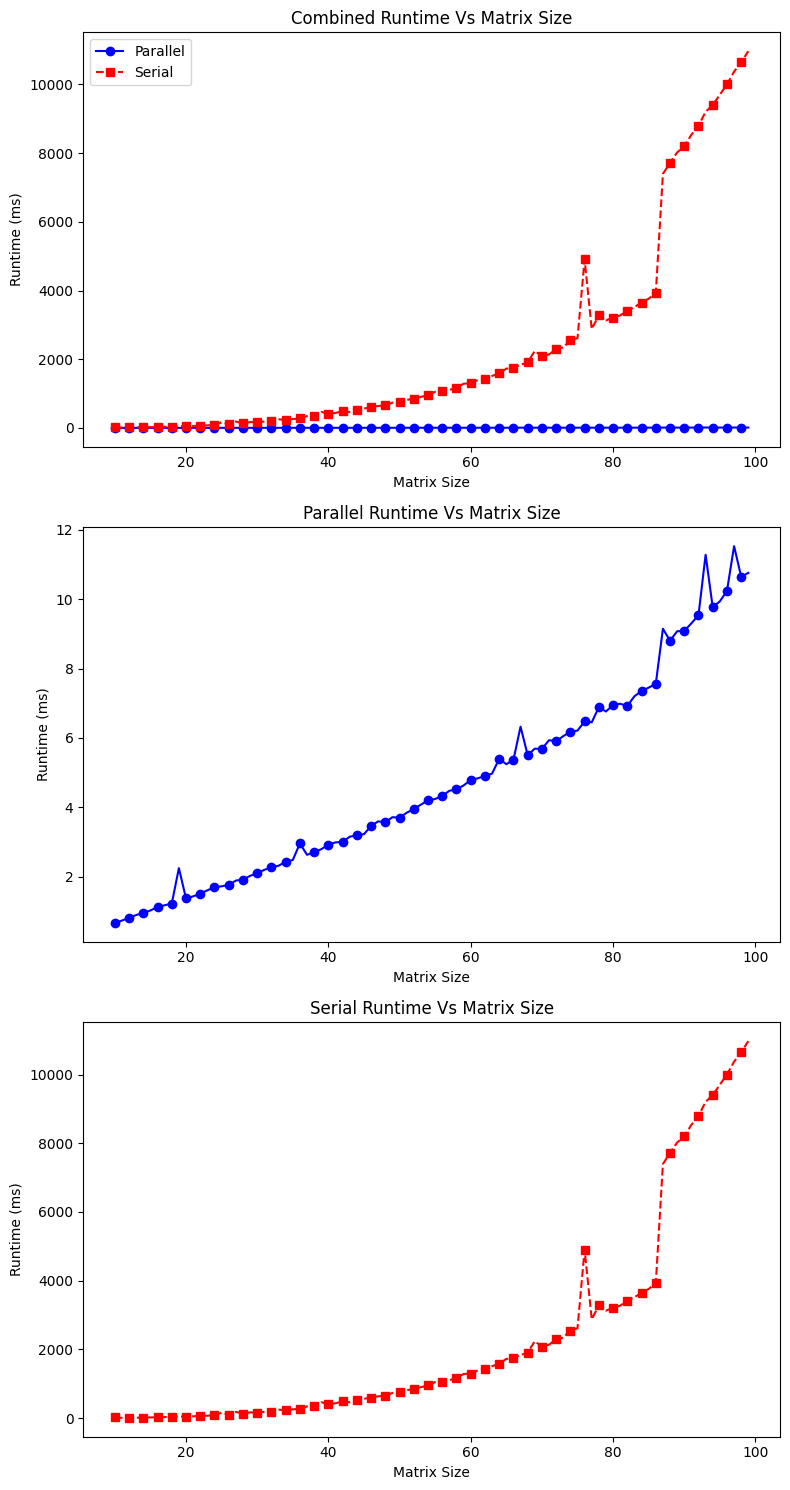

In [98]:
import subprocess
import matplotlib.pyplot as plt

max_N = 100  # define maximum N value
outputs = []
serial_outputs = []
N_values = list(range(10, max_N))  # define N_values

# Define colors
parallel_color = 'blue'
serial_color = 'red'

for n in N_values:
    output = subprocess.check_output(["./src/inverse", str(n)])
    output = output.strip()
    output = float(output)
    outputs.append(output)

    serial_output = subprocess.check_output(["./src/inverse_serial", str(n)])
    serial_output = serial_output.strip()
    serial_output = float(serial_output)
    serial_outputs.append(serial_output)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# Plot 1 - Combined Parallel and Serial
axs[0].plot(N_values, outputs, label='Parallel', marker='o', linestyle='-', markevery=2, color=parallel_color)
axs[0].plot(N_values, serial_outputs, label='Serial', marker='s', linestyle='--', markevery=2, color=serial_color)
axs[0].set_title('Combined Runtime Vs Matrix Size')
axs[0].set_xlabel('Matrix Size')
axs[0].set_ylabel('Runtime (ms)')
axs[0].legend()

# Plot 2 - Parallel Runtime
axs[1].plot(N_values, outputs, label='Parallel', marker='o', linestyle='-', markevery=2, color=parallel_color)
axs[1].set_title('Parallel Runtime Vs Matrix Size')
axs[1].set_xlabel('Matrix Size')
axs[1].set_ylabel('Runtime (ms)')

# Plot 3 - Serial Runtime
axs[2].plot(N_values, serial_outputs, label='Serial', marker='s', linestyle='--', markevery=2, color=serial_color)
axs[2].set_title('Serial Runtime Vs Matrix Size')
axs[2].set_xlabel('Matrix Size')
axs[2].set_ylabel('Runtime (ms)')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
